## Model for myelin plasticity

We are delaing with a network of interacting populations of neurons. The time evolution of the firing rate of the population $i$ can be expressed as:

$$\frac{d}{dt}r_i(t)=-r_i(t)+\frac{1}{N}\sum_{j=1}^N r_j(t)\gamma_{ij} w_{ij}+r'_i $$

The coincidence factor penalizes heterogeneous distributions of delays:

$$\gamma_{ij}=exp \Bigg[- \frac{\kappa}{2} \sum_{k=1}^N (\tau_{ij}-\tau_{kj})^2 \Bigg]$$ 

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
from scipy import stats
from scipy.stats import randint, poisson
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from scipy.spatial import distance
from tqdm.notebook import tqdm 

The following data comes from:
http://umcd.humanconnectomeproject.org/ 

- 68 Regions of Interest (cortical areas)

- Study Name: ICBM

- Imaging Modality: DTI

- Scan Parameters: Diffusion directions=30, B value=800

- Healty individuals 

- Age Range 18-90

- Gender: Mixed

- Subject Pool: ICBM normal subjects

- Group Size: 138

In [3]:
#ROIs names
Name = []
foldername = os.path.join(os.getcwd(), 'data', 'matrices', 'ICBM')
filename = os.path.join(foldername, 'freesurfer_regions_68_sort_full.txt')
name_file = open(filename, 'r')
for line in name_file.readlines():
    Name.append([line])
    for i in line.split(","):
        Name[-1].append(i)
Name=np.array(Name)
Name=Name[:,0]
for i in range(len(Name)):
    Name[i]=Name[i].rstrip() 
name_df=pd.DataFrame({'node name' : Name})
name_df

node name
0                   lh_bankssts
1    lh_caudalanteriorcingulate
2        lh_caudalmiddlefrontal
3                     lh_cuneus
4                 lh_entorhinal
5                   lh_fusiform
6           lh_inferiorparietal
7           lh_inferiortemporal
8           lh_isthmuscingulate
9           lh_lateraloccipital
10      lh_lateralorbitofrontal
11                   lh_lingual
12       lh_medialorbitofrontal
13            lh_middletemporal
14           lh_parahippocampal
15               lh_paracentral
16           lh_parsopercularis
17             lh_parsorbitalis
18          lh_parstriangularis
19             lh_pericalcarine
20               lh_postcentral
21        lh_posteriorcingulate
22                lh_precentral
23                 lh_precuneus
24  lh_rostralanteriorcingulate
25      lh_rostralmiddlefrontal
26           lh_superiorfrontal
27          lh_superiorparietal
28          lh_superiortemporal
29             lh_supramarginal
..                          ...
38                rh_entorhinal
39                  rh_fusiform
40          rh_inferiorparietal
41          rh_inferiortemporal
42          rh_isthmuscingulate
43          rh_lateraloccipital
44      rh_lateralorbitofrontal
45                   rh_lingual
46       rh_medialorbitofrontal
47            rh_middletemporal
48           rh_parahippocampal
49               rh_paracentral
50           rh_parsopercularis
51             rh_parsorbitalis
52          rh_parstriangularis
53             rh_pericalcarine
54               rh_postcentral
55        rh_posteriorcingulate
56                rh_precentral
57                 rh_precuneus
58  rh_rostralanteriorcingulate
59      rh_rostralmiddlefrontal
60           rh_superiorfrontal
61          rh_superiorparietal
62          rh_superiortemporal
63             rh_supramarginal
64               rh_frontalpole
65              rh_temporalpole
66        rh_transversetemporal
67                    rh_insula

[68 rows x 1 columns]

In [4]:
#P=nodes positions (3D coordinates)
filename = os.path.join(foldername, 'fs_region_centers_68_sort.txt')
P = np.loadtxt(fname = filename)

pos_df=pd.DataFrame({'node name' : Name,
'x': P[:,0],
'y': P[:,1],
'z': P[:,2]                       
})
pos_df.set_index('node name')

x          y          z
node name                                                   
lh_bankssts                 -56.452962 -47.393728   3.289199
lh_caudalanteriorcingulate   -4.660000  21.070000  29.770000
lh_caudalmiddlefrontal      -37.267652   6.311987  47.789819
lh_cuneus                    -4.574468 -85.354610  10.134752
lh_entorhinal               -24.254072  -1.517915 -29.726384
lh_fusiform                 -37.223154 -36.582215 -25.417785
lh_inferiorparietal         -37.027027 -74.962838  29.641892
lh_inferiortemporal         -51.318940 -24.107949 -26.985280
lh_isthmuscingulate          -5.688406 -48.355072  14.202899
lh_lateraloccipital         -28.227877 -90.660497  -4.558704
lh_lateralorbitofrontal     -26.880773  33.606874  -9.832438
lh_lingual                  -14.486957 -65.917391  -7.686957
lh_medialorbitofrontal       -6.363964  42.954955  -9.329730
lh_middletemporal           -58.849117 -28.030498 -13.351525
lh_parahippocampal          -24.971429 -27.126531 -19.681633
lh_paracentral               -5.975186 -31.846154  55.210918
lh_parsopercularis          -47.875887  14.329787  19.191489
lh_parsorbitalis            -44.334365  44.371517  -5.789474
lh_parstriangularis         -47.355509  33.476091   8.806653
lh_pericalcarine            -11.321212 -83.260606   2.557576
lh_postcentral              -45.828960 -25.205053  40.145773
lh_posteriorcingulate        -4.475162 -21.732181  38.557235
lh_precentral               -39.298478 -12.761085  43.268034
lh_precuneus                 -7.311703 -59.891078  34.876014
lh_rostralanteriorcingulate  -6.388889  41.277778   6.666667
lh_rostralmiddlefrontal     -32.459607  46.144105  22.784934
lh_superiorfrontal          -12.408883  26.502644  45.622136
lh_superiorparietal         -19.158658 -68.188577  43.031732
lh_superiortemporal         -53.927143  -8.060000  -5.931429
lh_supramarginal            -53.149826 -42.524390  29.421603
...                                ...        ...        ...
rh_entorhinal                20.974138  -1.732759 -30.724138
rh_fusiform                  36.463625 -28.811344 -27.691739
rh_inferiorparietal          45.593420 -67.909518  21.190364
rh_inferiortemporal          45.290859 -11.106187 -36.723915
rh_isthmuscingulate           9.133080 -46.228137  13.954373
rh_lateraloccipital          30.245659 -83.400643  -6.556913
rh_lateralorbitofrontal      23.199174  38.427245 -11.356037
rh_lingual                   15.733333 -64.031373  -8.466667
rh_medialorbitofrontal        4.498258  43.735192  -8.714286
rh_middletemporal            56.867601 -23.755452 -20.012461
rh_parahippocampal           26.554348 -23.913043 -22.304348
rh_paracentral                8.562900 -27.100213  53.432836
rh_parsopercularis           49.315136  17.171216  13.702233
rh_parsorbitalis             44.213400  40.674938  -6.292804
rh_parstriangularis          47.803607  36.597194  13.975952
rh_pericalcarine             16.750000 -75.210938   0.578125
rh_postcentral               45.871795 -24.384615  37.246548
rh_posteriorcingulate         6.800000 -18.310000  37.685000
rh_precentral                41.817088 -10.002407  40.949458
rh_precuneus                 11.266138 -58.545866  29.236693
rh_rostralanteriorcingulate   4.934579  40.887850   7.570093
rh_rostralmiddlefrontal      33.589716  47.161926  20.679431
rh_superiorfrontal           14.911819  26.193194  46.461032
rh_superiorparietal          23.544177 -65.700803  42.975904
rh_superiortemporal          54.021413  -2.098501  -9.982869
rh_supramarginal             54.549634 -33.109718  27.256008
rh_frontalpole                8.203125  69.234375  -1.531250
rh_temporalpole              30.690196  18.611765 -32.941176
rh_transversetemporal        47.781250 -17.406250   1.906250
rh_insula                    38.681818   3.863636  -0.794258

[68 rows x 3 columns]

In [5]:
N=len(P)
N

68

In [6]:
#we need 2D coordinates for 2D plots
Pxy=P[0:len(P),0:2]
Pyz=P[0:len(P),1:3]
Pxz=P[0:len(P),0:3:2]

In [16]:
#M=Connectivity matrix
filename = os.path.join(foldername, 'icbm_fiber_mat.txt')
M = np.loadtxt(fname = filename)
M = pd.DataFrame(M, dtype='float64')

In [8]:
M=np.array(M)
for i in range(len(M)):
    for j in range(len(M)):
        if M[i,j]<0.0002:
            M[i,j]=0
M=pd.DataFrame(M)

In [14]:
#compute eucledian distance between points in 3d space
axonal=distance.cdist(P,P,'euclidean')
axonal=pd.DataFrame(axonal, dtype='float64')

#eliminate zero weights from connectivity matrix in the axonal lengths matrix
boolM = (M > 0).astype('float64')
axonal = axonal * boolM
# for i in range(len(M)):
#     for j in range(len(M)):
#         if M[i][j]==0:
#             axonal[i][j]=0

Text(0.5,1,'Axonal lengths (mm)')

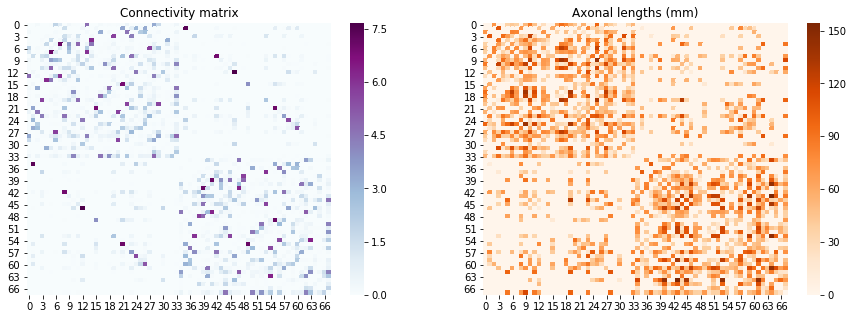

In [12]:
#display connectivity and axonal length matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = M, cmap="BuPu")
sns.heatmap(ax = ax2, data = axonal, cmap="Oranges")
ax1.set_title('Connectivity matrix')
ax2.set_title('Axonal lengths (mm)')

In [11]:
import time

#binary connectivity matrix
def weighted_to_binary(L):
    d=L.shape[0]
    L2=np.zeros((d,d))
    for i in range(d):
          for j in range(d):      
            if L[i,j] != 0:
                L2[i,j]=1
    return(L2)

start1 = time.time()
MB = (M > 0)
MB = pd.DataFrame(MB, dtype='float64')
end1 = time.time()

start2 = time.time()
MB=weighted_to_binary(np.array(M))
end2 = time.time()

print(end1 - start1)
print(end2 - start2)

0.0009980201721191406
0.0009970664978027344


### Let's start by setting constant velocities = 3 m/s and look at the changes operated by myelin plasticity

In [12]:
velocity=np.ones((N,N),dtype='float64')*3

In [13]:
delays=axonal/velocity   #the original delays

In [14]:
np.array(delays).min(), np.array(delays).max(), np.array(delays).mean(), np.array(delays).std()

(0.0, 51.43342980504136, 7.4065226986983985, 11.151965887046517)

### Algorithm

The process we are trying to model is typically more slower than the dynamics, then we refer to the steady state of the network $$r_i=\frac{1}{N}\sum_{j=1}^N r_j\gamma_{ij} w_{ij} + r'_i $$


Let's define an objective function and try to maximize it when updating the delay term: $$\tau_{ij}^{T+1}=\tau_{ij}^T + c \frac{d}{\tau_{ij}}E(r),$$ and interpret the learning rate c as the myelination rate. 

The objective function is 
$$E(r)= \frac{1}{2}\sum_{k=1}^N r_k^2$$ and we try to maximize it, with gradient ascent.

##### Compute the learning rule:
$$\tau_{ij}^{T+1}=\tau_{ij}^T + \eta \frac{d}{\tau_{ij}}L(r)=\tau_{ij}^T - \frac{1}{N} \eta \ \kappa \ r_i r_j w_{ij} \gamma_{ij} \Bigg[\sum_{h=1}^N (\tau_{ij}-\tau_{hj}) \Bigg]$$

In [15]:
#in the coincidence factor we take into account only nonzero delays 
def H(p):
    if p<=0:
        return(0)
    else:
        return(1)

In [16]:
eps=0.0005
#define the coincidence factors, collected in a matrix
def G(de):
    gamma=np.zeros((N,N),dtype='float64')
    for i in range(N):
            for j in range(N):
                s=0  #only when a connection exists
                for k in range(N):
                    s=s+((de[i][j]-de[k][j])**2)*H(de[k][j]) # No need for H(de[i][j]) here.
                    
                gamma[i,j]= np.exp(-s*eps/2)#*MB[i][j]          

    return(gamma)

In [17]:
gg=G(delays)
pd.DataFrame(gg,dtype='float64')

0         1         2         3         4         5         6   \
0   1.000000  1.000000  0.747143  1.000000  1.000000  0.436177  0.343711   
1   1.000000  1.000000  1.000000  0.090176  1.000000  1.000000  1.000000   
2   0.662439  1.000000  1.000000  1.000000  1.000000  1.000000  0.490199   
3   1.000000  0.151880  1.000000  1.000000  0.355928  0.655011  0.300373   
4   1.000000  1.000000  1.000000  0.195365  1.000000  0.458494  1.000000   
5   0.637613  1.000000  1.000000  0.461392  0.519705  1.000000  0.552824   
6   0.715471  1.000000  0.603024  0.424581  1.000000  0.664711  1.000000   
7   0.667810  1.000000  0.622345  1.000000  0.485696  0.188458  0.532932   
8   1.000000  0.608404  1.000000  0.405356  0.706883  0.642669  1.000000   
9   0.775697  1.000000  1.000000  0.310837  0.388604  0.679414  0.292877   
10  0.441317  1.000000  1.000000  0.030178  0.560271  0.619747  0.132545   
11  0.751910  1.000000  1.000000  0.308911  0.695454  0.511675  1.000000   
12  1.000000  0.741386  1.000000  1.000000  0.689455  1.000000  1.000000   
13  0.479433  1.000000  0.735286  1.000000  0.637736  0.283164  0.553124   
14  1.000000  1.000000  1.000000  0.462092  0.366362  0.162308  1.000000   
15  1.000000  0.724656  1.000000  1.000000  1.000000  1.000000  1.000000   
16  0.744524  1.000000  0.689508  1.000000  1.000000  1.000000  0.414450   
17  0.352673  1.000000  1.000000  1.000000  1.000000  0.473289  0.073451   
18  0.530114  1.000000  0.844013  1.000000  0.715844  0.546525  0.178174   
19  0.776954  1.000000  1.000000  0.133398  0.447826  0.682006  0.288117   
20  0.729633  1.000000  0.715013  1.000000  1.000000  1.000000  0.447222   
21  1.000000  0.736769  1.000000  0.453323  0.651094  1.000000  1.000000   
22  0.779445  1.000000  0.519688  1.000000  1.000000  1.000000  0.542400   
23  1.000000  0.475310  1.000000  0.389033  0.449848  0.633590  0.235220   
24  1.000000  0.629784  1.000000  1.000000  0.720953  1.000000  1.000000   
25  0.275183  0.701869  0.838214  1.000000  0.675173  0.285010  0.092985   
26  1.000000  0.468854  0.696780  1.000000  1.000000  1.000000  1.000000   
27  0.775329  1.000000  0.692668  0.430064  0.299502  0.561450  0.133102   
28  0.690837  1.000000  0.850616  0.213027  0.533767  0.469901  0.531846   
29  0.497426  1.000000  0.855602  1.000000  1.000000  1.000000  0.263977   
..       ...       ...       ...       ...       ...       ...       ...   
38  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
39  1.000000  1.000000  1.000000  1.000000  1.000000  0.603553  1.000000   
40  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
41  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
42  1.000000  0.616363  1.000000  0.445263  0.679641  1.000000  1.000000   
43  1.000000  1.000000  1.000000  0.419014  1.000000  1.000000  1.000000   
44  1.000000  1.000000  1.000000  1.000000  1.000000  0.264231  1.000000   
45  1.000000  1.000000  1.000000  0.381002  1.000000  0.681932  1.000000   
46  1.000000  0.743932  1.000000  1.000000  1.000000  1.000000  1.000000   
47  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
48  1.000000  1.000000  1.000000  1.000000  1.000000  0.674496  1.000000   
49  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
50  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
51  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
52  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
53  1.000000  1.000000  1.000000  0.279202  1.000000  1.000000  1.000000   
54  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
55  1.000000  0.727040  1.000000  1.000000  1.000000  1.000000  1.000000   
56  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
57  1.000000  0.474896  1.000000  0.398348  1.000000  1.000000  0.440703   
58  1.000000  0.635753  1.000000  1.000000  1.000000  1.00

In [18]:
np.array(gg).min(), np.array(gg).max(), np.array(gg).mean(), np.array(gg).std()

(0.0008216299264720995, 1.0, 0.7888434034637368, 0.3113012150159941)

In [19]:
#define the coincidence factors, collected in a matrix
def diff(de):
    diff=np.zeros((N,N),dtype='float64')
    for i in range(N):
            for j in range(N):
                s=0  
                for k in range(N):
                    
                    s=s+(de[i][j]-de[k][j])*H(de[i][j])*H(de[k][j])
                              
                diff[i,j]=s*MB[i][j]

    return(diff)

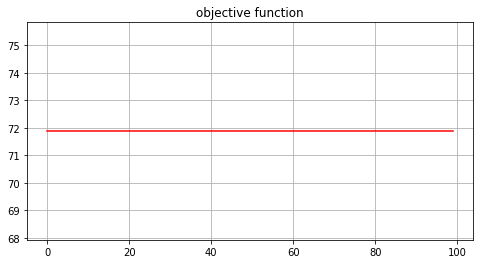

In [20]:
#compute the desired output
D=np.ones((N,N))*10

r_0=np.ones(N)                                   #baseline firing rate

R=[]

v=axonal/D 
g=G(D)
A = np.identity(N,dtype='float64')-(1/N)*(g*MB*(M))   
r = np.linalg.solve(A, r_0)
R.append(r)
RR=np.fromfunction(lambda i, j: r[i]*r[j], (N, N), dtype=int)
p=np.array(g*M,dtype='float64')  
C=0.9
D=D-C*p*diff(D)*RR*(1/N)*eps 

R1=np.transpose(R)
cost=np.zeros(len(R1.T))

for i in range(len(R1)): 
    R2=R1[i]**2
    cost=cost+R2
    
cost=cost/2

des=np.ones(100)*cost
  
plt.figure(figsize=(8,4))
plt.plot(des, 'r')
plt.title('objective function')
plt.grid(True)

In [21]:
time=range(6000)        #12 

In [22]:
D=np.array(axonal/velocity,dtype='float64')

r_0=np.ones(N)                                   #baseline firing rate

R=[]

for t in tqdm(time):
    
    v=axonal/D
    v=v.fillna(0)
    if np.min(D)>=0 and np.max(np.array(v))<100:
        g=G(D)        
  
    
        A = np.identity(N,dtype='float64')-(1/N)*(g*MB*(M))   
        r = np.linalg.solve(A, r_0)
    
        R.append(r)
    
        RR=np.fromfunction(lambda i, j: r[i]*r[j], (N, N), dtype=int)
    
        p=np.array(g*M,dtype='float64')  
        

        C=0.1/eps  #what is the optimal learning rate C? maybe a variable C is better!

        
        D=D-C*p*diff(D)*RR*(1/N)*eps 
    else:
        print(t)
        break      

  0%|          | 0/6000 [00:00<?, ?it/s]

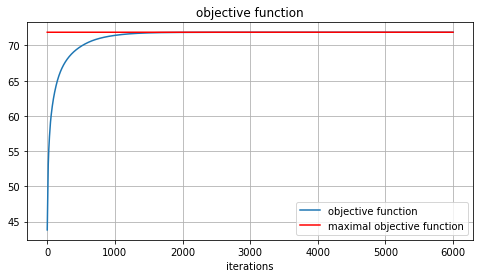

In [23]:
#plot the objective function, that has to be increasing
R1=np.transpose(R)
cost=np.zeros(len(R1.T))

for i in range(len(R1)): 
    R2=R1[i]**2
    cost=cost+R2
    
cost=cost/2

maximal=des[0]*np.ones(len(cost))
  
plt.figure(figsize=(8,4))
plt.plot(cost, label='objective function')
plt.plot(maximal, 'r', label='maximal objective function')
plt.title('objective function')
plt.xlabel('iterations')
#plt.ylabel('')
plt.legend()
plt.grid(True)

In [24]:
cost[-1]==cost[-2]

False

In [25]:
#some statistics before and after the algorithm
np.mean(gg),np.mean(g), np.mean(gg)<np.mean(g)

(0.7888434034637368, 0.9999999938955144, True)

In [26]:
np.array(delays).std()**2, np.array(D).std()**2, np.array(delays).std()**2>np.array(D).std()**2

(124.3663431458492, 156.31443326920703, False)

In [27]:
#velocities adjusted by myelin
velocity2=axonal/D
velocity2=velocity2.fillna(0)

In [28]:
np.array(velocity2).max()

5.317329994057762

In [29]:
np.array(velocity2).min()

0.0

In [30]:
np.array(velocity2).mean()

0.8828377826082919

In [31]:
np.array(delays).max(), np.array(D).max()

(51.43342980504136, 36.69424919919952)

In [32]:
np.array(delays).mean(), np.array(D).mean()

(7.4065226986983985, 9.42557306073289)

In [33]:
np.array(delays).std(), np.array(D).std()

(11.151965887046517, 12.502577065117697)

Text(0.5,1,'Where they differ? (boolean values, 0=differ)')

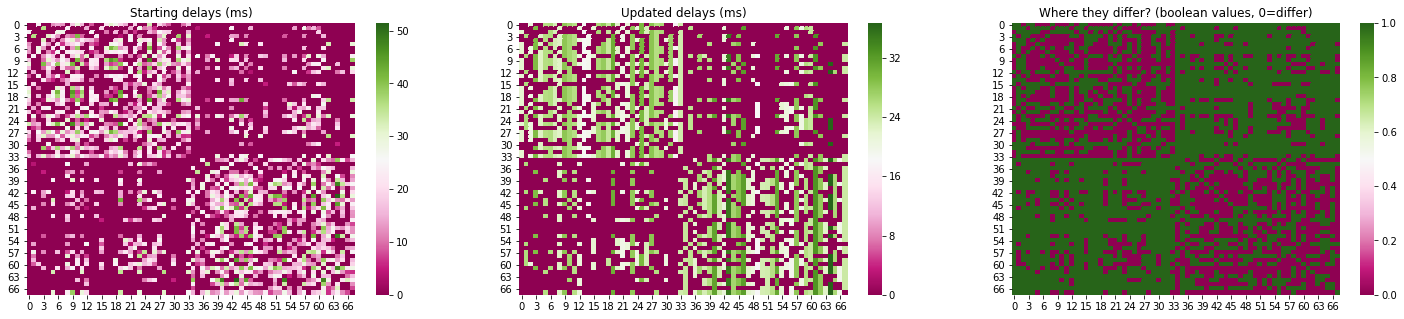

In [34]:
#plot delays matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
sns.heatmap(ax = ax1, data = delays, cmap="PiYG")
sns.heatmap(ax = ax2, data = D, cmap="PiYG")
sns.heatmap(ax = ax3, data = np.array(D==delays), cmap="PiYG")
ax1.set_title('Starting delays (ms)')
ax2.set_title('Updated delays (ms)')
ax3.set_title('Where they differ? (boolean values, 0=differ)')

Text(0.5,1,'Updated delays (ms)')

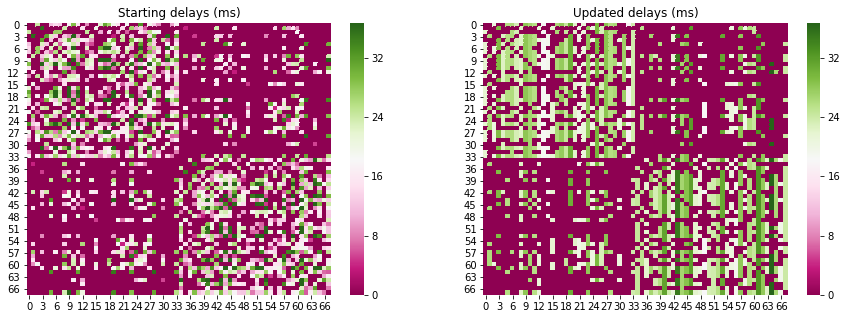

In [35]:
v=0
V=np.array(D).max() 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = delays, vmin=v, vmax=V, cmap="PiYG")
sns.heatmap(ax = ax2, data = D, vmin=v, vmax=V, cmap="PiYG")
ax1.set_title('Starting delays (ms)')
ax2.set_title('Updated delays (ms)')

Text(0.5,1,'Updated velocities (m/s)')

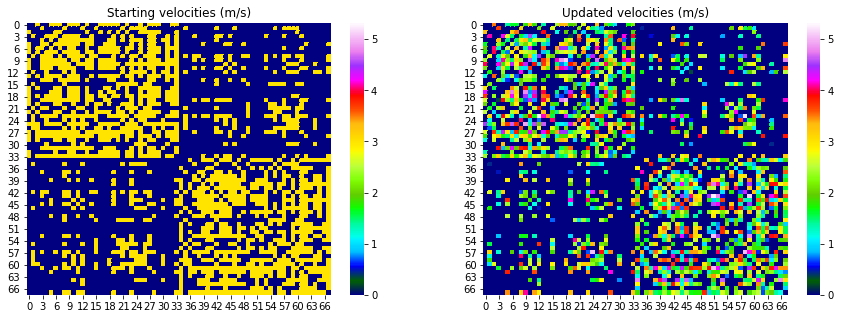

In [36]:
#plot velocities matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
v=0
V=np.array(velocity2).max()
sns.heatmap(ax = ax1, data = velocity*MB, vmin=v, vmax=V, cmap="gist_ncar")
sns.heatmap(ax = ax2, data = velocity2*MB, vmin=v, vmax=V, cmap="gist_ncar")
ax1.set_title('Starting velocities (m/s)')
ax2.set_title('Updated velocities (m/s)')

Text(0.5,1,'Updated gamma')

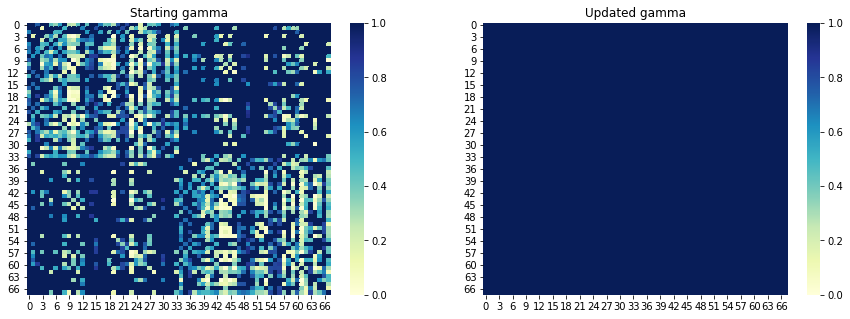

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
g2=G(D)
v=0
V=(np.array(g2)).max()
sns.heatmap(ax = ax1, data = gg, vmin=v, vmax=V, cmap="YlGnBu")
sns.heatmap(ax = ax2, data = g2, vmin=v, vmax=V, cmap="YlGnBu")  #YlGnBu GnBu YlOrRd
ax1.set_title('Starting gamma')
ax2.set_title('Updated gamma')

In [38]:
gamma1=[]
gamma2=[]

g2=G(D)

for i in range(N):
    for j in range(N):
        if M[i][j]!=0:
            gamma1.append(gg[i][j])
            gamma2.append(g2[i][j])
np.mean(gamma1), np.std(gamma1)**2, np.mean(gamma2), np.std(gamma2)**2

(0.43167165169750826,
 0.05783842115669651,
 0.9999999836026775,
 2.301604945529438e-14)

Text(0.5,1,'Updated velocities (m/s)')

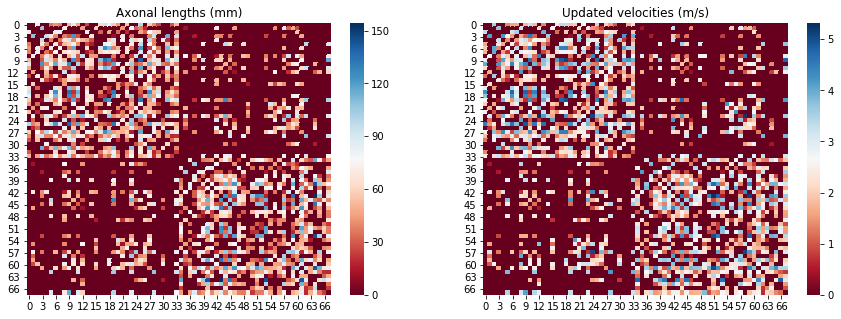

In [39]:
#display velocity and axonal length matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.heatmap(ax = ax1, data = axonal, cmap="RdBu")
sns.heatmap(ax = ax2, data = velocity2, cmap="RdBu")
ax1.set_title('Axonal lengths (mm)')
ax2.set_title('Updated velocities (m/s)')

Text(0.5,1,'difference')

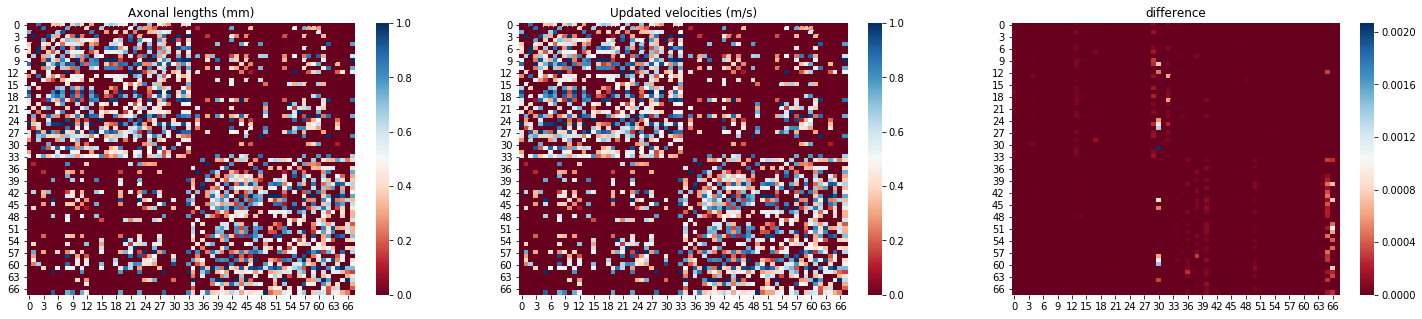

In [40]:
#what is the difference between the two? (normalizaed matrices)
diff_vel_axo = np.abs(velocity2/np.max(velocity2) - axonal/np.max(axonal))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
sns.heatmap(ax = ax1, data = velocity2/np.max(velocity2), cmap="RdBu")
sns.heatmap(ax = ax2, data = axonal/np.max(axonal), cmap="RdBu")
sns.heatmap(ax = ax3, data = diff_vel_axo, cmap="RdBu")
ax1.set_title('Axonal lengths (mm)')
ax2.set_title('Updated velocities (m/s)')
ax3.set_title('difference')

In [41]:
#distance/similarity between two matrices: Frobenius distance
frob1=np.linalg.norm(velocity/np.max(velocity) - axonal/np.max(axonal))
frob2=np.linalg.norm(velocity2/np.max(velocity2) - axonal/np.max(axonal))
frob1, frob2

(57.89206496222408, 0.004532970398255817)

In [42]:
#prepare histograms
histv1=[]
histv2=[]
histd1=[]
histd2=[]
hista=[]

for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            histv1.append(velocity[i][j])
            histv2.append(velocity2[i][j])
            histd1.append(delays[i][j])
            histd2.append(D[i][j])
            hista.append(axonal[i][j])           

In [43]:
np.mean(histv1), np.mean(histv2), np.mean(histd1), np.mean(histd2)

(3.0, 2.3761594335161473, 19.934668776939116, 25.368946352054067)

In [44]:
np.std(histv1)**2, np.std(histv2)**2, np.std(histd1)**2, np.std(histd2)**2

(0.0, 1.0903759712030774, 84.98778728878001, 16.253988404619527)

Text(0.5,0,'time delay (ms)')

C:\Users\Daniel\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


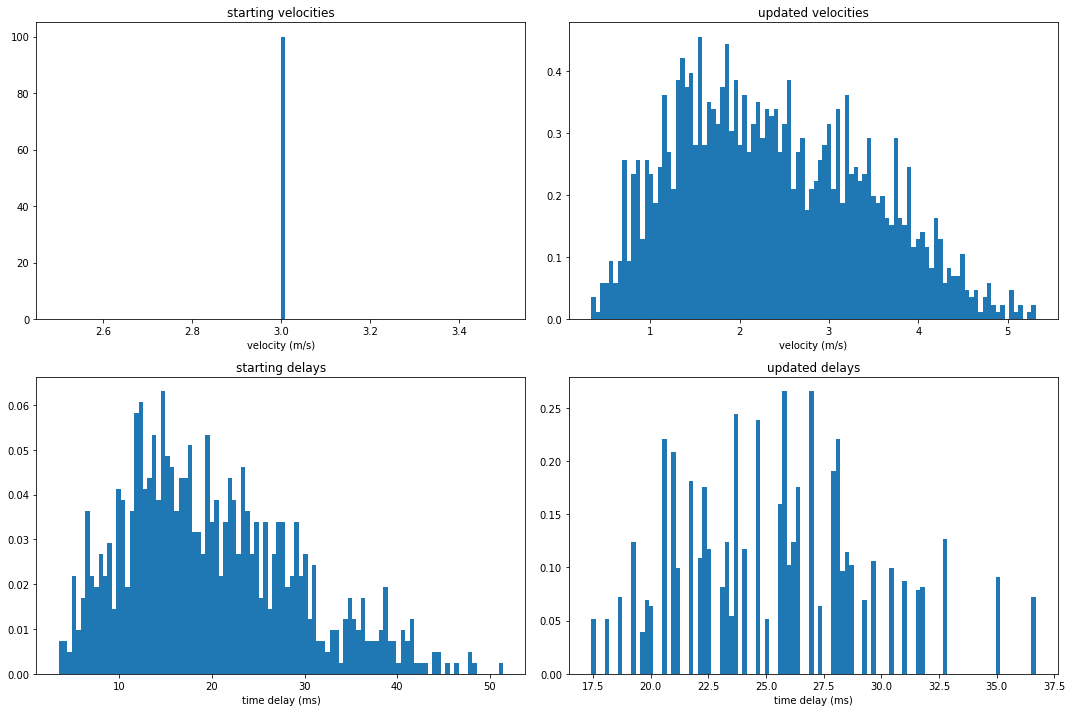

In [45]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(15,10))

n=100

axs[0][0].hist(histv1, bins=n, density=True)
axs[0][1].hist(histv2, bins=n, density=True)
axs[1][0].hist(histd1, bins=n, density=True)
axs[1][1].hist(histd2, bins=n, density=True)

axs[0][0].set_title('starting velocities')
axs[0][1].set_title('updated velocities')
axs[1][0].set_title('starting delays')
axs[1][1].set_title('updated delays')

axs[0][0].set_xlabel('velocity (m/s)')
axs[0][1].set_xlabel('velocity (m/s)')
axs[1][0].set_xlabel('time delay (ms)')
axs[1][1].set_xlabel('time delay (ms)')

In [46]:
from scipy.stats import pearsonr
pearsonr(histv2,hista)

(0.9289561572056466, 0.0)

Text(0.5,0,'axonal length (mm)')

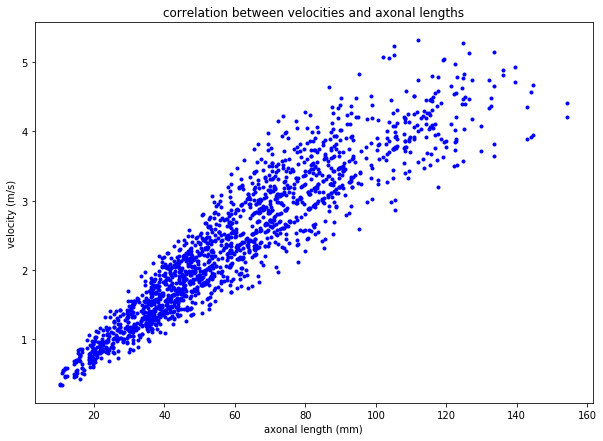

In [47]:
plt.figure(figsize=(10,7))
plt.scatter(hista, histv2, c='blue', marker='.')
plt.title('correlation between velocities and axonal lengths')
plt.ylabel('velocity (m/s)')
plt.xlabel('axonal length (mm)')

C:\Users\Daniel\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


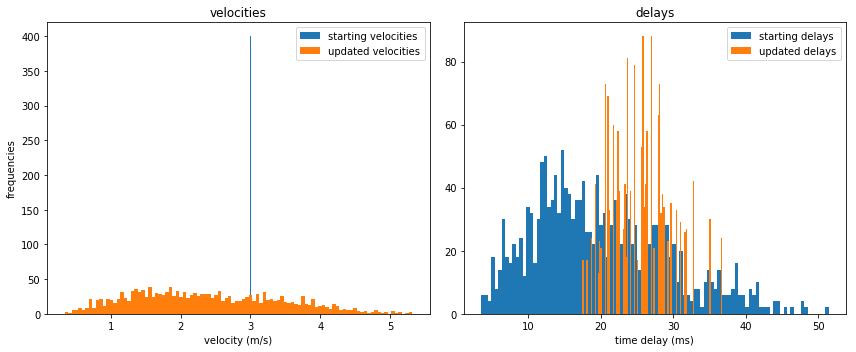

In [48]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12,5))

n=100

axs[0].hist(histv1[:400], bins=n)
axs[0].hist(histv2, bins=n)
axs[1].hist(histd1, bins=n)
axs[1].hist(histd2, bins=n)

axs[0].set_title('velocities')
axs[1].set_title('delays')

axs[0].set_xlabel('velocity (m/s)')
axs[1].set_xlabel('time delay (ms)')

axs[0].set_ylabel('frequencies')

axs[0].legend(['starting velocities ', 'updated velocities'])
axs[1].legend(['starting delays ', 'updated delays'])

### Graphical results: how the network changes

In [49]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            li.append([i,j,velocity[i][j]])#/np.linalg.norm(np.array(velocity))])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            li2.append([i,j,velocity2[i][j]])#/np.linalg.norm(np.array(velocity2))])
            
G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

G2 = nx.DiGraph() 
G2.add_weighted_edges_from(li2)

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

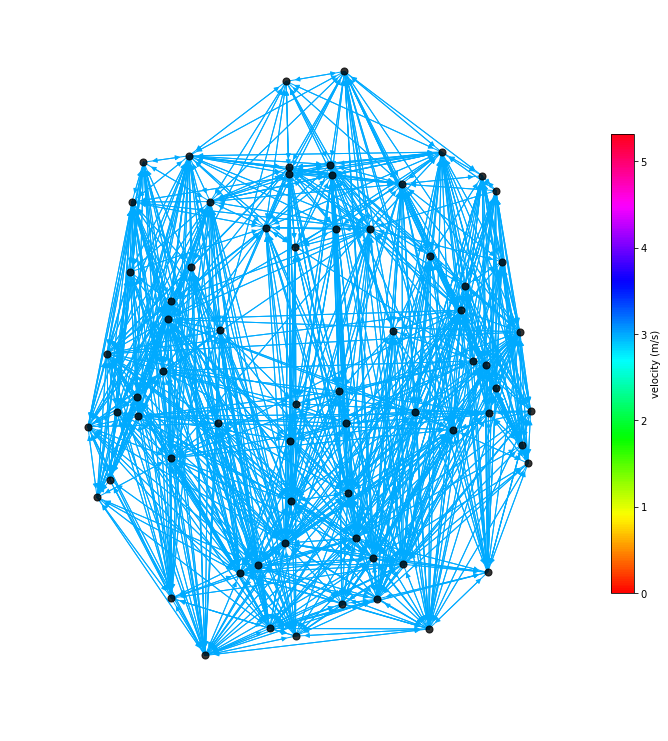

In [50]:
#Plotting network with colormap based on initial velocity: Axial plane
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pxy, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pxy, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('assial plan')
plt.axis('off')
plt.show()

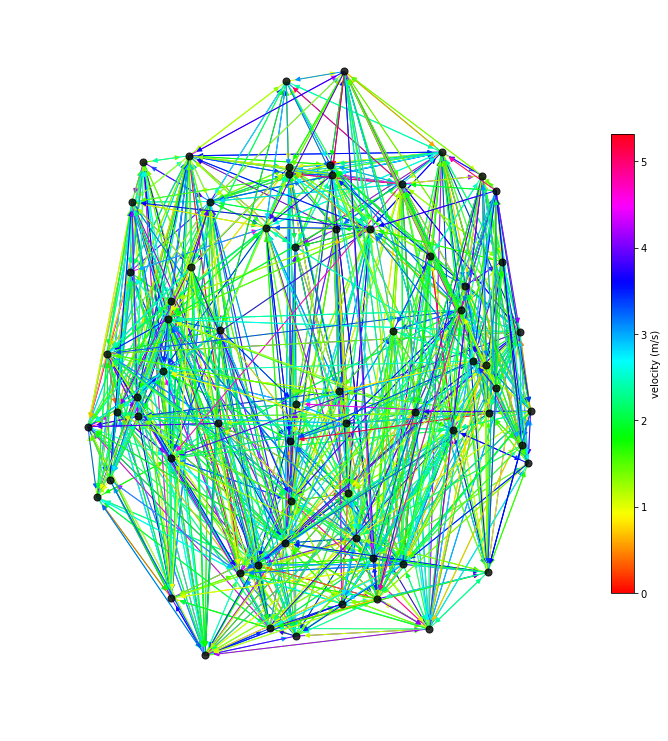

In [51]:
#Plotting network with colormap based on updated velocity: Axial plane
plt.figure(figsize=(12, 13))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pxy, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pxy, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label ="velocity (m/s)")

#plt.title('assial plan')
plt.axis('off')
plt.show()

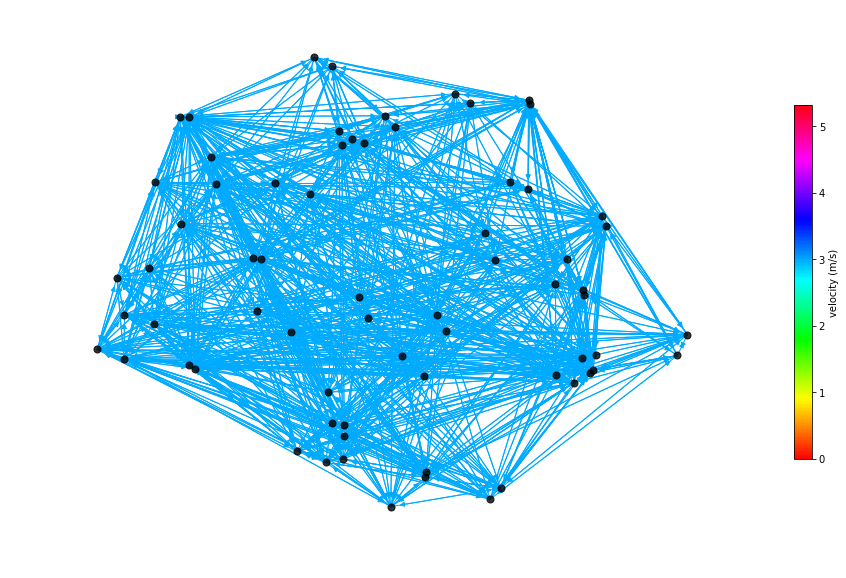

In [52]:
#Sagittal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pyz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('sagittal plan')
plt.axis('off')
plt.show()

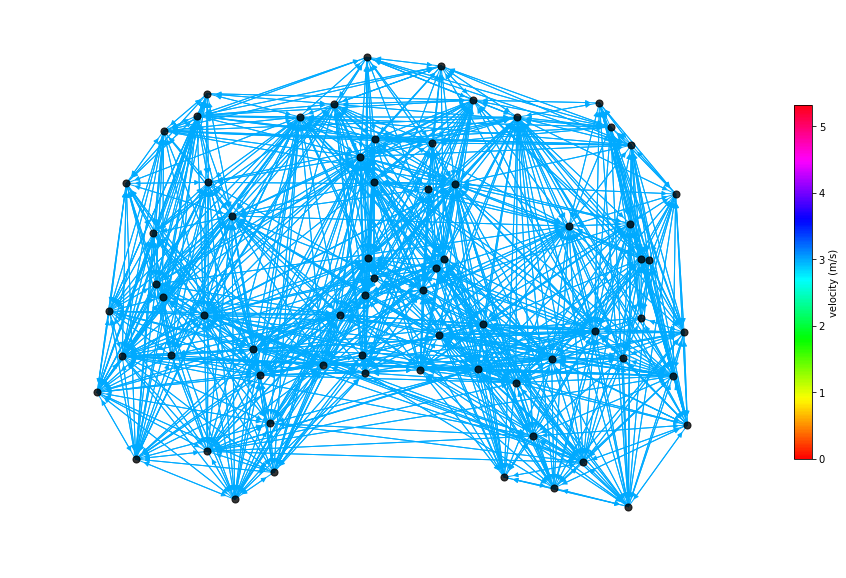

In [53]:
#Coronal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G1, Pxz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G1, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")

#plt.title('coronal plan')
plt.axis('off')
plt.show()

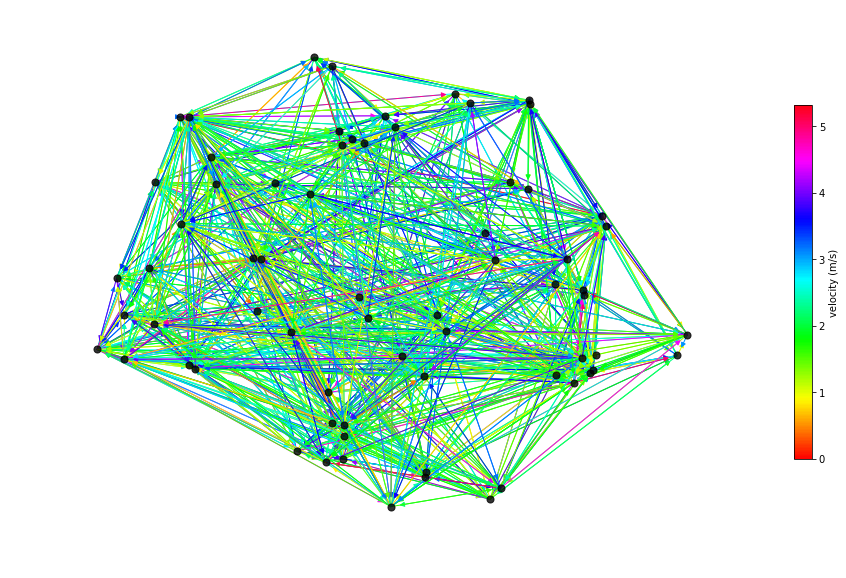

In [54]:
#Sagittal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pyz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")


plt.axis('off')
plt.show()

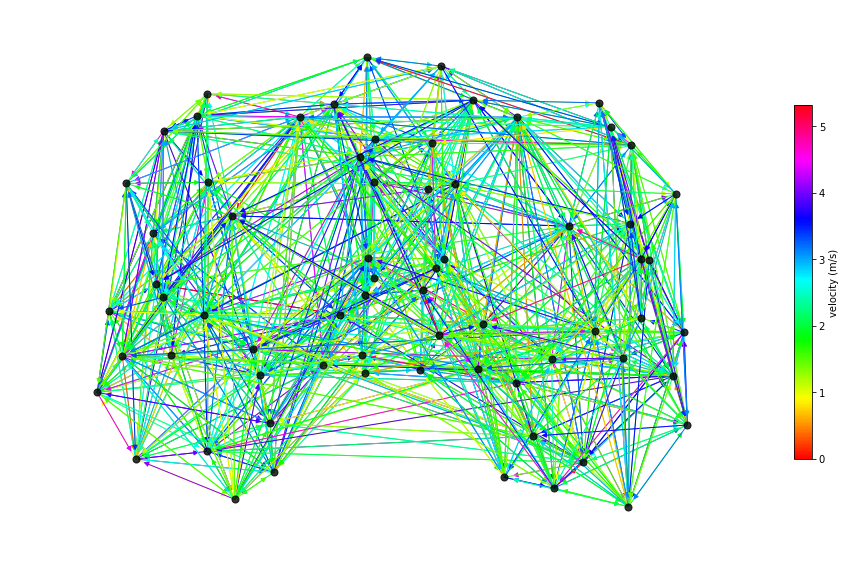

In [55]:
#Coronal plane
plt.figure(figsize=(16, 10))

vmin = np.min(np.array(velocity2))
vmax = np.max(np.array(velocity2))

edge=nx.draw_networkx_edges(G2, Pxz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.hsv, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_nodes(G2, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.hsv, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="velocity (m/s)")


plt.axis('off')
plt.show()

#### Graph with weighted link: delays

In [56]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li.append([i,j,delays[i][j]/np.linalg.norm(np.array(delays))])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li2.append([i,j,D[i][j]/np.linalg.norm(np.array(D))])
            
          
    
    
G3 = nx.DiGraph() 
G3.add_weighted_edges_from(li)

G4 = nx.DiGraph() 
G4.add_weighted_edges_from(li2)

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

In [57]:
li=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li.append([i,j,delays[i][j]])

li2=[]
for i in range(N):
    for j in range(N):
        if axonal[i][j]!=0:
            #if i<j:
            li2.append([i,j,D[i][j]])
            
            
G1 = nx.DiGraph() 
G1.add_weighted_edges_from(li)

G2 = nx.DiGraph() 
G2.add_weighted_edges_from(li2)            
                

l=[]
for i in range(len(li)):
    l.append(li[i][2])

l2=[]
for i in range(len(li2)):
    l2.append(li2[i][2])

In [58]:
vmin=np.min(np.array(delays))
vmax=np.max(np.array(delays))

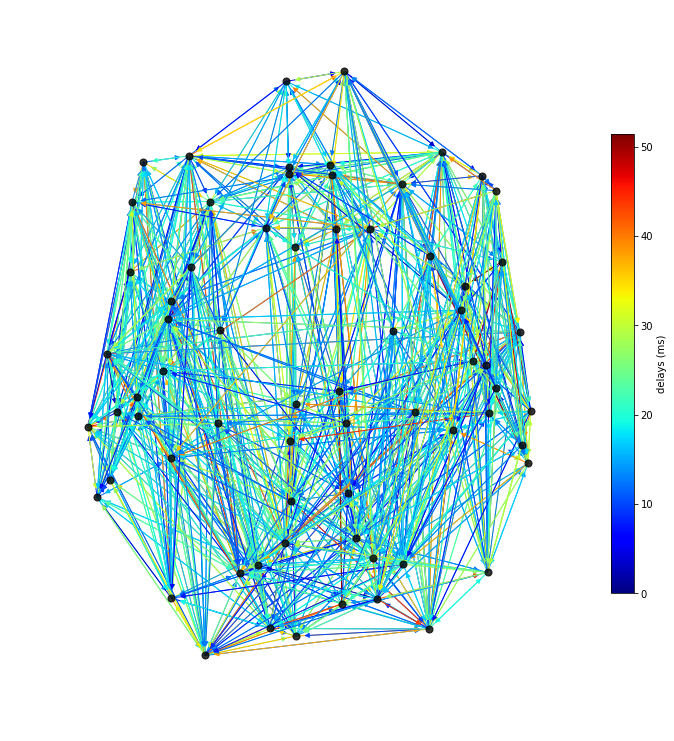

In [59]:
#Plotting network with colormap based on delay: Axial plane
plt.figure(figsize=(12, 13))

edge=nx.draw_networkx_edges(G3, Pxy, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pxy, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")


#plt.title('axial plane', size=20)
plt.axis('off')
plt.show()

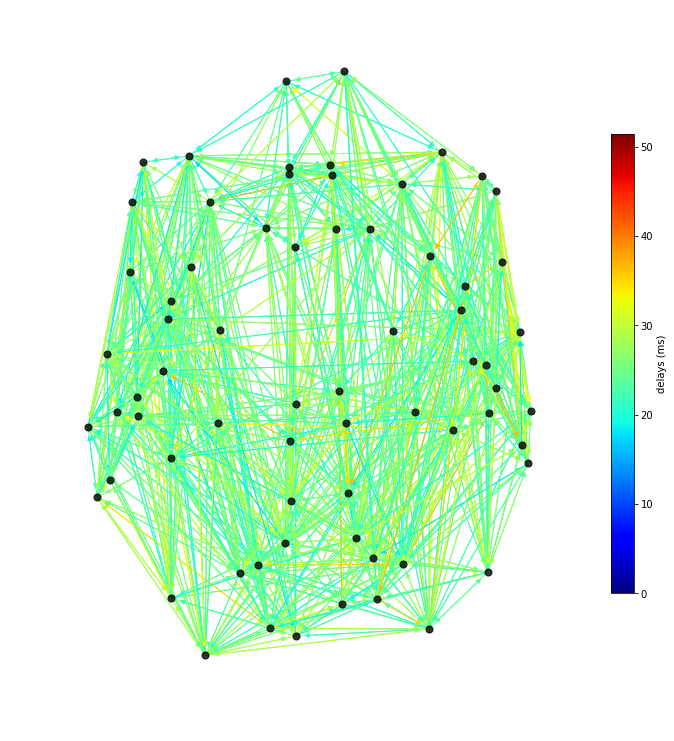

In [60]:
#Plotting network with colormap based on updated delay: Axial plane
plt.figure(figsize=(12, 13))

edge=nx.draw_networkx_edges(G4, Pxy, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pxy, node_size=50.0, alpha=0.8, node_color='black') #node_color=list(dict(nx.degree(G)).values())

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")


#plt.title('axial plane',size=20)
plt.axis('off')
plt.show()

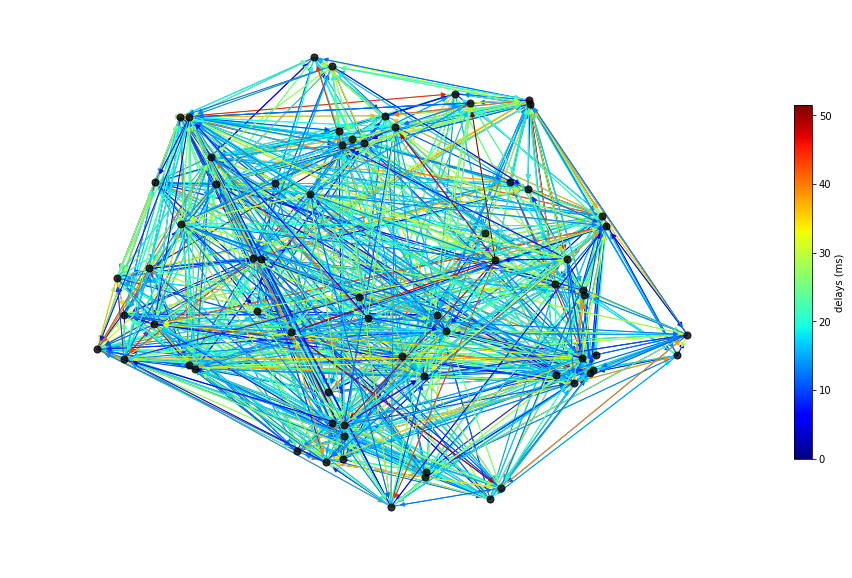

In [61]:
#Sagittal plane
plt.figure(figsize=(16, 10))


edge=nx.draw_networkx_edges(G3, Pyz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

#plt.title('sagittal plan')
plt.axis('off')
plt.show()

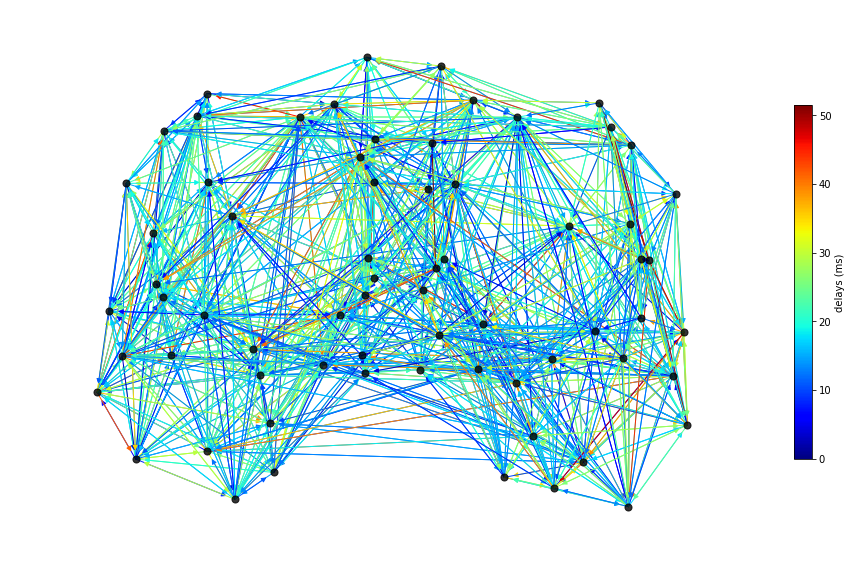

In [62]:
#Coronal plane
plt.figure(figsize=(16, 10))

edge=nx.draw_networkx_edges(G3, Pxz, alpha=0.8, edge_color=l, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G3, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

#plt.title('coronal plan')
plt.axis('off')
plt.show()

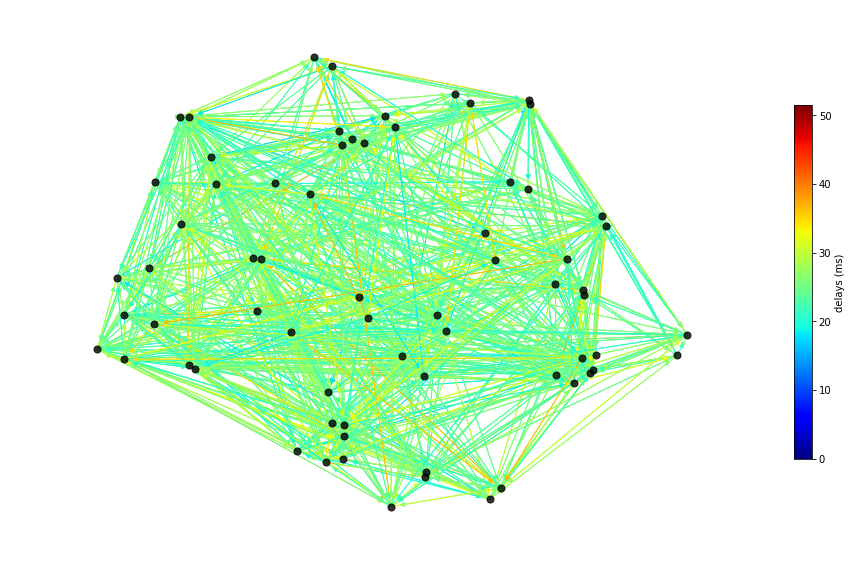

In [63]:
#Sagittal plane
plt.figure(figsize=(16, 10))



edge=nx.draw_networkx_edges(G4, Pyz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pyz, node_size=50.0, alpha=0.8, node_color='black') 


sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

plt.axis('off')
plt.show()

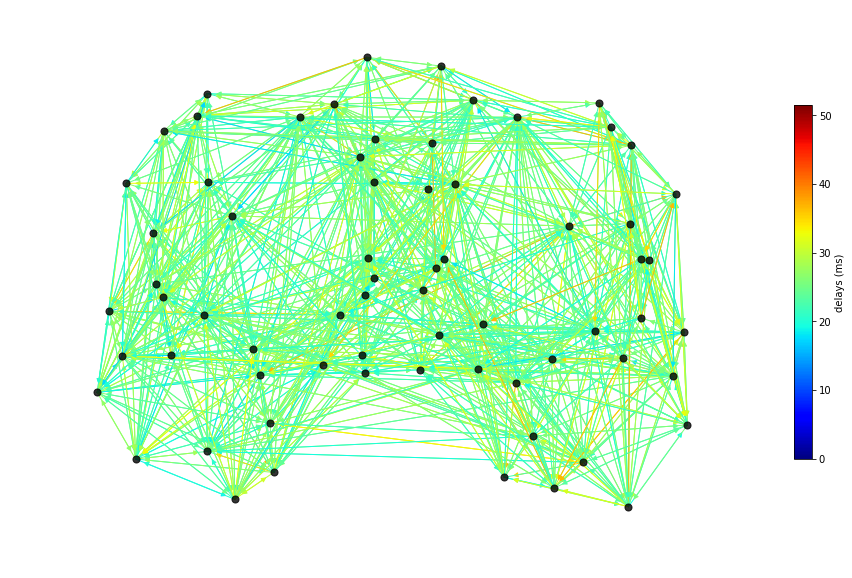

In [64]:
#Coronal plane
plt.figure(figsize=(16, 10))



edge=nx.draw_networkx_edges(G4, Pxz, alpha=0.8, edge_color=l2, edge_cmap=plt.cm.jet, edge_vmin=vmin,edge_vmax=vmax)

nx.draw_networkx_nodes(G4, Pxz, node_size=50.0, alpha=0.8, node_color='black') 

sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,shrink=0.65, label="delays (ms)")

plt.axis('off')
plt.show()